In [0]:
from torchvision import transforms, datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
import torch.nn.functional as F

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [121]:
# Image preprocessing 
                              

transformation = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


# Divide into training and validation sets and load it

training_dataset = datasets.CIFAR10(root = '/.date',download=True, train=True, transform = transformation)
validation_dataset = datasets.CIFAR10(root = '/.date',download=True, train=False, transform = transformation)
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Convert tensors to numpy array in order to work with matplotlib

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image





In [0]:
# Define all classes with names instead of number
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

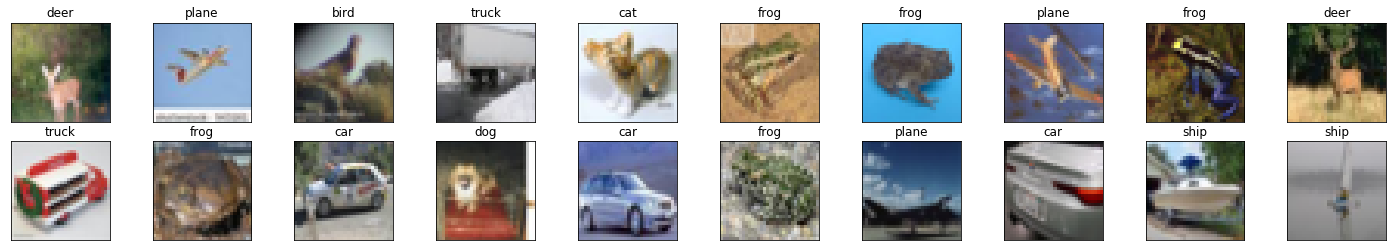

In [124]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  
            

In [0]:
##   Old Model
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,20,5,1) # 3 input color channel, 20 outout channels, kernel matrix size is 5, stride is 1 (32-5=)
    self.conv2 = nn.Conv2d(20,50, 5, 1)
    
    self.fc1 = nn.Linear(5*5*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 5*5*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [0]:
# Upgraded Model with 3 conv layers
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,1, padding = 1) # 3 input color channel, 16 outout channels, stride is 1
    self.conv2 = nn.Conv2d(16,32, 3, 1, padding = 1)  # Include padding to preserve edge pixels and max feature extraction
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1) # change kernel size to 3 to reduce overfitting
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [130]:
model = LeNet().to(device) # input:784, hidden_lay1=125, hidden_layer2=65, output=10
model


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [132]:

epochs = 15
running_loss_history=[]
running_correct_history=[]
val_running_loss_history=[]
val_running_loss_corrects_history=[]

print("Initializing Training and Validation ........")
print("Please Wait...")

for e in range(epochs):
  running_loss=0.0
  running_correct = 0.0
  
  val_running_loss=0.0
  val_running_corrects=0.0
  
  
  for inputs, labels in training_loader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    # inputs = inputs.view(inputs.shape[0], -1)
    output= model(inputs)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(output, 1)
    running_loss+=loss.item()
    running_correct +=torch.sum(preds == labels.data)
    
  else:
    with torch.no_grad():
      
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_output= model(val_inputs)
        val_loss = criterion(val_output, labels)
        _, val_preds = torch.max(val_output, 1)
        val_running_loss+=val_loss.item()
        val_running_corrects +=torch.sum(val_preds == val_labels.data)
    
    
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_correct.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_loss_corrects_history.append(val_epoch_acc)
    
    
    print("Epoch: ", (e+1))
    
    print('Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    
    print('validation loss: {:.4f}, Validation Acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
    
print("-----Completed----- ")    

Initializing Training and Validation ........
Please Wait...
Epoch:  1
Training loss: 1.5764, Accuracy: 42.1700
validation loss: 3.9755, Validation Acc: 51.6900
Epoch:  2
Training loss: 1.2140, Accuracy: 56.6720
validation loss: 4.9445, Validation Acc: 59.0300
Epoch:  3
Training loss: 1.0457, Accuracy: 63.1280
validation loss: 5.2355, Validation Acc: 62.8800
Epoch:  4
Training loss: 0.9370, Accuracy: 67.1780
validation loss: 5.5527, Validation Acc: 64.8700
Epoch:  5
Training loss: 0.8469, Accuracy: 70.3940
validation loss: 5.8708, Validation Acc: 67.7900
Epoch:  6
Training loss: 0.7848, Accuracy: 72.4580
validation loss: 6.4081, Validation Acc: 68.7800
Epoch:  7
Training loss: 0.7238, Accuracy: 74.5820
validation loss: 7.0715, Validation Acc: 69.8600
Epoch:  8
Training loss: 0.6756, Accuracy: 76.0620
validation loss: 6.9330, Validation Acc: 70.9500
Epoch:  9
Training loss: 0.6301, Accuracy: 77.7200
validation loss: 7.6238, Validation Acc: 71.3000
Epoch:  10
Training loss: 0.5875, Accur

Validation accuracy is much better than previous model after adding additional conv layer

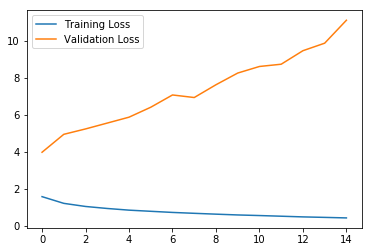

In [133]:
plt.plot(running_loss_history, label = "Training Loss")
plt.plot(val_running_loss_history, label = "Validation Loss")
plt.legend()

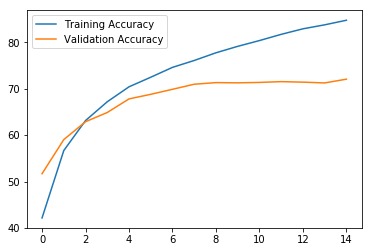

In [134]:
plt.plot(running_correct_history, label = "Training Accuracy")
plt.plot(val_running_loss_corrects_history, label = "Validation Accuracy")
plt.legend()

In [0]:
import requests
from PIL import ImageOps
from PIL import Image

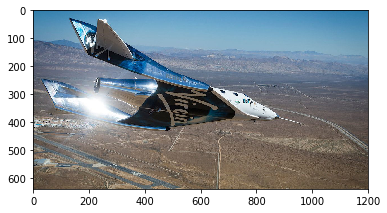

In [136]:
# Test image from online source.

url = 'https://www.geekgirlauthority.com/wp-content/uploads/2019/08/space-plane-1200x640.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)                   

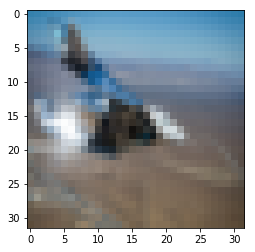

In [137]:

img = transformation(img)
plt.imshow(im_convert(img))
                         

In [138]:
# img = img.view(img.shape[0], -1)
# output = model(img)
# 
image = img.to(device).unsqueeze(0)

output = model(image)
_, pred = torch.max(output,1)
print(classes[pred.item()])


plane


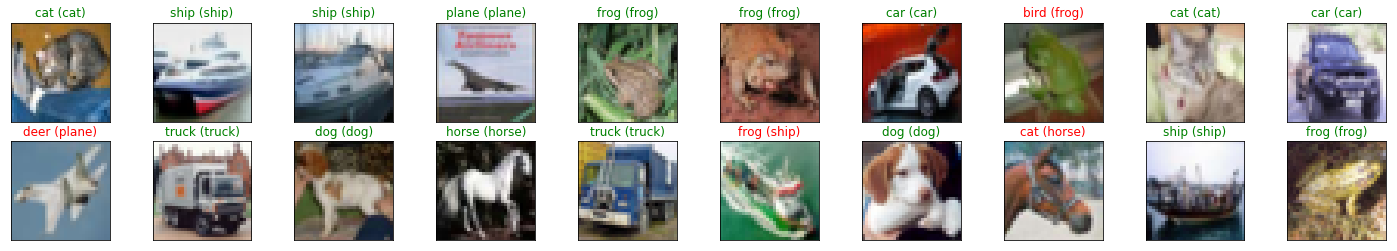

In [139]:
val_dataiter = iter(validation_loader)
images, labels = val_dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=('green' if preds[idx] ==labels[idx] else 'red'))
  